# **Projet Télédétection Landes - Marion BILLY**

## I - Introduction

Série temporelle Sentinel-2 utilisée: Bretagne 24-25   
*2025-03-31     
2025-04-10	  
2025-05-15	  
2025-06-17	  
2025-07-12	  
2025-08-10*  

Echantillon: PI_strates_bretagne.shp   
Champ strate qui contient les labels numériques des classes:   
*1	Sol Nu    
2	Herbe    
3	Landes    
4	Arbre*    

Extraction des séries temporelles par bande Sentinel, chaque bande d’un fichier correspondant à une date (même ordre que ci-dessus)

In [5]:
# import des librairies
import sys
sys.path.append("/home/onyxia/work")
import geopandas as gpd
import os
import numpy as np

# personal librairies
from libsigma import read_and_write as rw

Les images Sentinel-2 sont initialement fournies sous forme de séries temporelles par bande. Afin de faciliter les analyses ultérieures, les bandes ont été regroupées par date pour produire une image multibande Sentinel-2 par date.

In [6]:
base_path = "/home/onyxia/work/data/projet_eval/"
bands = ["B02","B03","B04","B05","B06","B07","B08","B8A","B11","B12"]
dates = ["2025-03-31","2025-04-10","2025-05-15","2025-06-17","2025-07-12","2025-08-10"]

for i, date in enumerate(dates):
    band_arrays = []
    for band in bands:
        filename = os.path.join(base_path, f"bretagne_24-25_{band}.tif")
        arr = rw.load_img_as_array(filename)  # shape = (lignes, colonnes, nb_dates)
        # extraire la bande correspondant à la date i
        single_band = arr[:, :, i]
        # s'assurer que c'est 3D pour write_image
        band_arrays.append(np.atleast_3d(single_band))
    
    # concaténer toutes les bandes pour cette date
    all_bands = np.dstack(band_arrays)  # shape = (lignes, colonnes, nb_bandes)
    
    out_filename = os.path.join(base_path, f"bretagne_{date}.tif")
    rw.write_image(out_filename, all_bands, data_set=rw.open_image(os.path.join(base_path, f"bretagne_24-25_{bands[0]}.tif")))
    print(f"Fichier créé pour {date} -> {out_filename}")

/opt/python/lib/python3.13/site-packages/osgeo/gdal.py:330: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Fichier créé pour 2025-03-31 -> /home/onyxia/work/data/projet_eval/bretagne_2025-03-31.tif
Fichier créé pour 2025-04-10 -> /home/onyxia/work/data/projet_eval/bretagne_2025-04-10.tif
Fichier créé pour 2025-05-15 -> /home/onyxia/work/data/projet_eval/bretagne_2025-05-15.tif
Fichier créé pour 2025-06-17 -> /home/onyxia/work/data/projet_eval/bretagne_2025-06-17.tif
Fichier créé pour 2025-07-12 -> /home/onyxia/work/data/projet_eval/bretagne_2025-07-12.tif
Fichier créé pour 2025-08-10 -> /home/onyxia/work/data/projet_eval/bretagne_2025-08-10.tif


## II - Analyse des échantillons

### 1. Nombre d'échantillons

In [7]:
import matplotlib.pyplot as plt

gdf = gpd.read_file("/home/onyxia/work/data/projet_eval/PI_strates_bretagne_32630.shp")
gdf.head()

,id,strate,comment,geometry
0,1,3,lande basse,"POLYGON ((441224.58 5366298.317, 441224.779 53..."
1,2,3,lande basse,"POLYGON ((441649.972 5366251.139, 441650.172 5..."
2,3,3,lande basse,"POLYGON ((441383.597 5366193.034, 441384.395 5..."
3,4,2,None,"POLYGON ((441336.658 5366402.088, 441337.257 5..."
4,5,2,None,"POLYGON ((441062.121 5366343.165, 441062.919 5..."


#### Diagramme en bâton du nombre de polygones par classe, diag_baton_nb_poly_by_class.png

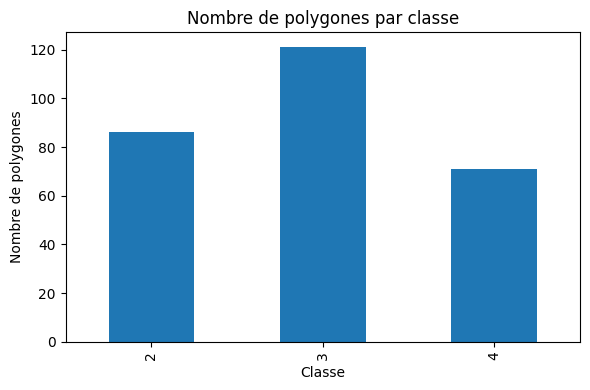

In [11]:
nb_poly = gdf["strate"].value_counts().sort_index()
plt.figure(figsize=(6,4))
nb_poly.plot(kind="bar")
plt.xlabel("Classe")
plt.ylabel("Nombre de polygones")
plt.title("Nombre de polygones par classe")
plt.tight_layout()
plt.savefig("/home/onyxia/work/results/figure/diag_baton_nb_poly_by_class.png", dpi=300)
plt.show()

#### Diagramme en bâton du nombre de pixel par classe, diag_baton_nb_pix_by_class.png

In [12]:
from libsigma import classification as cla

# Rasteriser les échantillons
vector_samples = "/home/onyxia/work/data/projet_eval/PI_strates_bretagne_32630.shp"
ref_image = "/home/onyxia/work/data/projet_eval/bretagne_2025-03-31.tif"  # une image Sentinel-2 de référence
raster_samples = "/home/onyxia/work/data/projet_eval/raster_strates.tif"

cla.rasterization(
    in_vector=vector_samples,
    ref_image=ref_image,
    out_image=raster_samples,
    field_name="strate",
    dtype="int16"
)

array_samples = rw.load_img_as_array(raster_samples)
array_samples = array_samples[:, :, 0]
classes, counts = np.unique(array_samples, return_counts=True)
pixel_counts = {int(c): int(n) for c, n in zip(classes, counts)}
pixel_counts
class_labels = {1: "Sol Nu", 2: "Herbe", 3: "Landes", 4: "Arbre"}
labels = [class_labels[c] for c in pixel_counts.keys()]
values = list(pixel_counts.values())

# Histogramme
plt.figure(figsize=(6,4))
plt.bar(labels, values)
plt.xlabel("Classe")
plt.ylabel("Nombre de pixels Sentinel-2")
plt.title("Nombre de pixels par classe")
plt.tight_layout()
#plt.savefig("results/figure/diag_baton_nb_pix_by_class.png", dpi=300)
plt.show()

otbcli_Rasterization -in /home/onyxia/work/data/projet_eval/PI_strates_bretagne_32630.shp -im /home/onyxia/work/data/projet_eval/bretagne_2025-03-31.tif -out /home/onyxia/work/data/projet_eval/raster_strates.tif -mode attribute -mode.attribute.field strate int16


CalledProcessError: Command 'otbcli_Rasterization -in /home/onyxia/work/data/projet_eval/PI_strates_bretagne_32630.shp -im /home/onyxia/work/data/projet_eval/bretagne_2025-03-31.tif -out /home/onyxia/work/data/projet_eval/raster_strates.tif -mode attribute -mode.attribute.field strate int16' returned non-zero exit status 127.

### 2. Phénologie des strates, mise en évidence des landes

### 3. Production d’une d’essence forestière à l’échelle du pixel